In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18  
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F  # Added this import

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def predict_and_display_image(model, image_path):
    # Load the model into evaluation mode
    model.eval()
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    # Check if the image has 4 channels (RGBA)
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    preprocessed_image = transform(image).unsqueeze(0)  # Add a batch dimension

    # Make a prediction
    with torch.no_grad():
        output = model(preprocessed_image)

    predicted_class = 1 if output <= 0.5 else 0  # Assuming 0.5 as the threshold

    # Display the image and prediction
    image_array = np.array(image)
    plt.imshow(image_array)
    plt.title(f"Prediction: {'Accepted' if predicted_class == 1 else 'Not Accepted'}")
    plt.axis('off')
    plt.show()
    return predicted_class

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(root="organized_photos", transform=transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Training the Model


In [3]:
model=SimpleCNN()

In [4]:

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels.float().unsqueeze(1)).item()
            predicted = (outputs >= 0.5).squeeze().long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Testing loop
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        test_loss += criterion(outputs, labels.float().unsqueeze(1)).item()
        predicted = (outputs >= 0.5).squeeze().long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
# Save the model to a file
torch.save(model.state_dict(), 'Photo_classifierV1.pth')


c:\Users\shafe\Applications\Anaconda3\envs\ML\lib\site-packages\PIL\Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/10, Loss: 0.0535, Val Loss: 1.5183, Val Accuracy: 0.9206
Epoch 2/10, Loss: 0.0798, Val Loss: 1.1910, Val Accuracy: 0.9259
Epoch 3/10, Loss: 0.3354, Val Loss: 0.9956, Val Accuracy: 0.9365
Epoch 4/10, Loss: 0.0696, Val Loss: 0.7928, Val Accuracy: 0.9471
Epoch 5/10, Loss: 0.1126, Val Loss: 0.8555, Val Accuracy: 0.9524
Epoch 6/10, Loss: 0.0117, Val Loss: 1.6742, Val Accuracy: 0.8995
Epoch 7/10, Loss: 0.0386, Val Loss: 0.8758, Val Accuracy: 0.9524
Epoch 8/10, Loss: 0.1975, Val Loss: 1.0514, Val Accuracy: 0.9524
Epoch 9/10, Loss: 0.2780, Val Loss: 0.7284, Val Accuracy: 0.9524
Epoch 10/10, Loss: 0.0028, Val Loss: 1.3888, Val Accuracy: 0.9471
Test Loss: 1.1774, Test Accuracy: 0.9579


In [4]:
torch.save(model, 'Photo_ClassifierV1.pt')

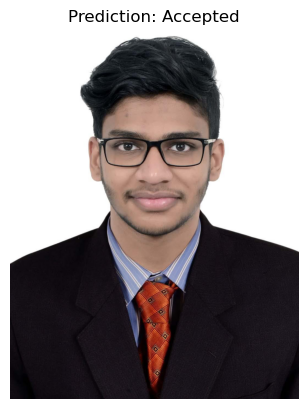

1

In [5]:
model.load_state_dict(torch.load('Photo_classifierV1.pth'))
predict_and_display_image(model=model,image_path= "./test_images/212221240048.jpeg")

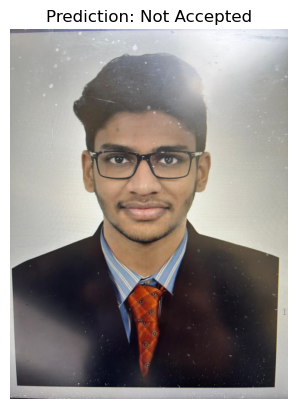

0

In [9]:
predict_and_display_image(model=model,image_path="./test_images/image.jpg")